## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('AZN-AstraZeneca.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845531,4590000
2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783772,3948200
2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330799,5668200
2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083755,2490000
2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757294,5283900
...,...,...,...,...,...,...
2024-05-24,78.129997,78.889999,78.080002,78.540001,78.540001,3566600
2024-05-28,77.779999,77.820000,76.489998,76.620003,76.620003,4199000
2024-05-29,76.129997,76.510002,75.800003,76.080002,76.080002,4653800


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.6)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
23/23 - 10s - 435ms/step - loss: 0.0271
Epoch 2/50
23/23 - 2s - 91ms/step - loss: 0.0070
Epoch 3/50
23/23 - 2s - 94ms/step - loss: 0.0054
Epoch 4/50
23/23 - 2s - 93ms/step - loss: 0.0047
Epoch 5/50
23/23 - 2s - 92ms/step - loss: 0.0045
Epoch 6/50
23/23 - 2s - 94ms/step - loss: 0.0044
Epoch 7/50
23/23 - 2s - 95ms/step - loss: 0.0045
Epoch 8/50
23/23 - 3s - 112ms/step - loss: 0.0049
Epoch 9/50
23/23 - 3s - 143ms/step - loss: 0.0046
Epoch 10/50
23/23 - 4s - 168ms/step - loss: 0.0042
Epoch 11/50
23/23 - 3s - 128ms/step - loss: 0.0038
Epoch 12/50
23/23 - 4s - 159ms/step - loss: 0.0035
Epoch 13/50
23/23 - 4s - 154ms/step - loss: 0.0036
Epoch 14/50
23/23 - 3s - 110ms/step - loss: 0.0036
Epoch 15/50
23/23 - 5s - 232ms/step - loss: 0.0033
Epoch 16/50
23/23 - 3s - 121ms/step - loss: 0.0032
Epoch 17/50
23/23 - 3s - 119ms/step - loss: 0.0030
Epoch 18/50
23/23 - 3s - 112ms/step - loss: 0.0034
Epoch 19/50
23/23 - 2s - 99ms/step - loss: 0.0031
Epoch 20/50
23/23 - 3s - 124ms/step - loss: 0.

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step


## Calculate the error of the model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
# Evaluate the accuracy of test

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)


print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.018918666410023887
RMSE on Test dataset:  1.5845319054055373
MSLE on Test dataset:  0.0005636344075741821
MAE on Test dataset:  1.2562935855533242


## Predict Close price for 90 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Predict Close price for 90 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_90_days = []

for i in range(90):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_90_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

In [14]:
# Show the result of predict 90 next days 
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1))
print(y_next_90_days.flatten())

[75.99897  75.831696 75.5983   75.3133   75.013306 74.72314  74.4537
 74.20801  73.98601  73.78679  73.60927  73.45211  73.31384  73.19276
 73.08696  72.994446 72.9134   72.84188  72.77807  72.72026  72.66684
 72.61644  72.56776  72.51972  72.471405 72.42198  72.37092  72.31772
 72.26205  72.20367  72.142494 72.07848  72.01163  71.94212  71.87015
 71.79576  71.71941  71.64133  71.56181  71.48113  71.39966  71.31757
 71.23523  71.15282  71.07054  70.988625 70.90726  70.82657  70.746704
 70.66773  70.58971  70.51271  70.43674  70.36171  70.28775  70.21484
 70.14289  70.07198  70.002    69.932816 69.864395 69.79684  69.729965
 69.66374  69.59812  69.53306  69.4685   69.404396 69.340706 69.27741
 69.214455 69.15182  69.089485 69.02741  68.9656   68.90404  68.8427
 68.781586 68.72069  68.66001  68.59953  68.53929  68.47925  68.419426
 68.35983  68.30046  68.24132  68.1824   68.123726 68.0653  ]


## Model visualization

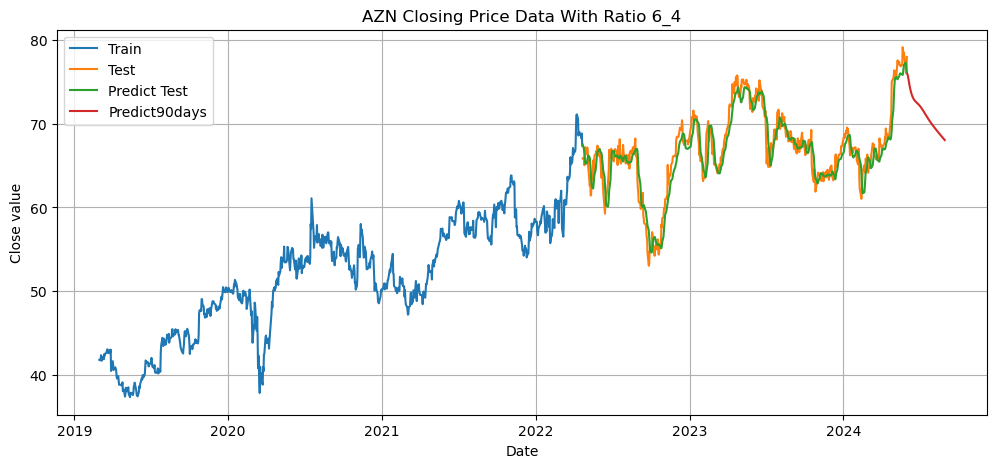

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 90 next days
plt.plot(index_next_90_days, y_next_90_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict90days'])
plt.grid()
plt.title("AZN Closing Price Data With Ratio 6_4")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_64_90days_AZN.png')
plt.show()